In [1]:
import os

import numpy as np
import importlib
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation
from sklearn.decomposition import PCA


import gym_env
import utils
from utils import create_mapping, get_transition_matrix, create_mapping_nb, get_full_maze_values

In [2]:
# Save dir
save_dir = os.path.join('..', 'figures/')

## SR-IS Model

In [3]:
class SR_IS:
    def __init__(self, env_name, alpha=0.1, beta=1, gamma=0.904, _lambda=1.0, epsilon=0.4, num_steps=25000, policy="random", imp_samp=True, diff_type="Max"):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_locs = self.env.unwrapped.target_locs
        self.maze = self.env.unwrapped.maze
        self.walls = self.env.unwrapped.get_walls()
        self.size = self.maze.size - len(self.walls)   # Size of the state space is the = size of maze - number of blocked states
        self.height, self.width = self.maze.shape

        # Create mapping and Transition matrix
        self.mapping = create_mapping_nb(self.maze, self.walls)
        self.reverse_mapping = {index: (i, j) for (i, j), index in self.mapping.items()}
        self.T = get_transition_matrix(self.env, self.mapping)
        

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # Set reward
        self.reward_nt = -0.1
        self.reward_t = -0.1
        self.r = np.full(len(self.T), self.reward_nt)
        self.r[self.terminals] = self.reward_t
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)
        # Precalculate exp(r) for use with LinearRL equations
        self.expr_nt = np.exp(self.reward_nt / _lambda)

        # Params
        self.alpha = alpha
        self.beta = beta
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.policy = policy
        self.imp_samp = imp_samp
        self.diff_type = diff_type

        # Model
        self.DR = self.get_DR()
        self.Z = np.full(self.size, 0.01)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def get_states(self):
        """
        Returns all non-blocked states as well as a mapping of each state (i,j) -> to an index (k)
        """
        states = []
        index_mapping = {}
        index = 0
        for i in range(len(self.maze)):
            for j in range(len(self.maze[i])):
                if self.maze[i][j] in ['0', 'S', 'G']:
                    states.append((i, j))
                    index_mapping[(i, j)] = index
                    index += 1

        return states, index_mapping

    def get_DR(self):
        """
        Returns the DR initialization based on what decision policy we are using, values are filled with 0.01 if using softmax to avoid div by zero
        """
        if self.policy == "random":
            DR = np.eye(self.size)
            DR[np.where(self.terminals)[0], np.where(self.terminals)[0]] = (1/(1-self.gamma))
        
        elif self.policy == "softmax":
            DR = np.full((self.size, self.size), 0.01)
            np.fill_diagonal(DR, 1)
            DR[np.where(self.terminals)[0], np.where(self.terminals)[0]] = (1/(1-self.gamma))

        return DR

    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = self.expr_t
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_prob):
        """
        Performs importance sampling P(x'|x)/u(x'|x). P(.) is the default policy, u(.) us the decision policy
        """
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state):
        """
        Action selection based on our policy
        Options are: [random, softmax, egreedy, test]
        """
        if self.policy == "random":
            return self.env.unwrapped.random_action()
        
        elif self.policy == "softmax":
            successor_states = self.env.unwrapped.get_successor_states(state)      # succesor_states = [(state, terminated), ...]
            action_probs = np.full(self.env.action_space.n, 0.0)

            v_sum = sum(
                        np.exp((np.log(self.Z[self.mapping[(s[0][0],s[0][1])]] + 1e-20)) / self.beta) for s in successor_states
                        )

            # if we don't have enough info, random action
            if v_sum == 0:
                return self.env.unwrapped.random_action() 

            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction
                
                action_probs[action] = np.exp((np.log(self.Z[self.mapping[(new_state[0], new_state[1])]] + 1e-20)) / self.beta ) / v_sum

            action = np.random.choice(self.env.action_space.n, p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob

    def get_D_inv(self):
        """
        Calculates the DR directly using matrix inversion, used for testing
        """
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)

        return D_inv

    def learn(self, seed):
        """
        Agent explores the maze according to its decision policy and and updates its DR as it goes
        """
        self.env.reset(seed=seed, options={})
        
        D_inv_1 = self.get_D_inv()
        D_inv_2 = np.linalg.inv(np.diag(np.exp(-self.r/self._lambda))-self.T)
        diff_1, diff_2 = list(), list()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Update terminal state information after 2 steps
            if i == 2:
                self.Z[self.terminals] = self.expr_t

            # Every 10 steps check difference
            if (i + 1) % 1 == 0:
                if self.diff_type == "Max":
                    diff_1.append(np.max(np.abs(D_inv_1 - self.DR)))
                    diff_2.append(np.max(np.abs(D_inv_2 - (self.gamma * self.DR))))
                elif self.diff_type == "Mean":
                    diff_1.append(np.mean(np.abs(D_inv_1 - self.DR)))
                    diff_2.append(np.mean(np.abs(D_inv_2 - (self.gamma * self.DR))))
                elif self.diff_type == "Median":
                    diff_1.append(np.median(np.abs(D_inv_1 - self.DR)))
                    diff_2.append(np.median(np.abs(D_inv_2 - (self.gamma * self.DR))))
                    
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action
            if self.policy == "softmax":
                action, s_prob = self.select_action(state)
            else:
                action = self.select_action(state)
        
            # Take action
            obs, _, done, _, _ = self.env.step(action)

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Importance sampling
            if self.policy == "softmax" and self.imp_samp:
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
            else:
                w = 1
            
            ## Update default representation
            target = self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]
            self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * target * w

            ## Update Z-Values
            self.Z = self.DR[:,~self.terminals] @ self.P @ self.expr_t

            if done:
                self.env.reset(seed=seed, options={})
                continue
            
            # Update state
            state = next_state

        # Update DR at terminal state
        self.update_V()

        return [diff_1, diff_2]

### Save Path

In [4]:
save_dir = os.path.join('..', 'figures/')
save_path = save_dir + 'convergence_4room.png'

## Test Different Temperature Values and Num Steps

In [5]:
envs = ["simple-5x5", "tolman-9x9-nb", "four-room-tr"]
env_name = envs[2]
diff_types = ["Max", "Mean", "Median"]
diff_type = diff_types[1]
num_steps = 2500000
num_runs = 15

diffs_with_imp = []
diffs_no_imp = []

for i in range(num_runs):
    print(f"run: {i+1}")
    diffs_with_imp_run = []
    diffs_no_imp_run = []

    agent = SR_IS(env_name=env_name, _lambda=1.0, alpha=0.05, beta=1.0, num_steps=num_steps, policy="softmax", imp_samp=True, diff_type=diff_type)
    agent_no_imp = SR_IS(env_name=env_name, _lambda=1.0, alpha=0.05, beta=1.0, num_steps=num_steps, policy="softmax", imp_samp=False, diff_type=diff_type)
    # Get the diffs for both agents
    diffs_1 = agent.learn(seed=int(i))
    diffs_2 = agent_no_imp.learn(seed=int(i))
    # Append the differences
    diffs_with_imp_run.append(diffs_1)
    diffs_no_imp_run.append(diffs_2)
    
    diffs_with_imp.append(diffs_with_imp_run)
    diffs_no_imp.append(diffs_no_imp_run)

run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15


In [6]:
diffs_with_imp = np.array(diffs_with_imp)
diffs_no_imp = np.array(diffs_no_imp)

## Single Plot

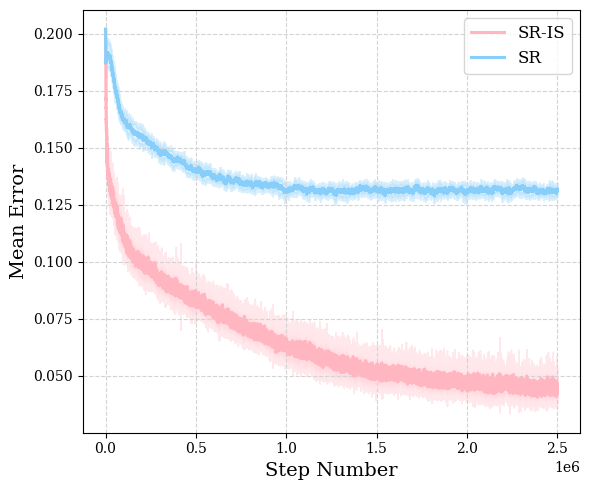

In [7]:
# Save path
save_path = save_dir + 'convergence_four_room_2million.png'
# save_path = None

# Calculate mean and standard deviation across the runs
mean_diffs_with_imp = np.mean(diffs_with_imp, axis=0)
std_diffs_with_imp = np.std(diffs_with_imp, axis=0)

mean_diffs_no_imp = np.mean(diffs_no_imp, axis=0)
std_diffs_no_imp = np.std(diffs_no_imp, axis=0)

# Set a nicer font
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(6, 5))  # Adjust these values as needed

# Define pastel colors
colors = ['#FFB6C1', '#FFD700', '#98FB98', '#87CEFA', '#FFA07A']

# Softmax agents
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# fig.suptitle(f"{diff_type} Errors", fontsize=16)  # Title for all subplots

x = np.arange(num_steps)
# plt.figure(figsize=(6.5,7))
# Plot mean convergence curves with shaded regions for standard deviation
plt.plot(x, mean_diffs_with_imp[0][1], label='SR-IS', color=colors[0], linewidth=2.2)
plt.fill_between(x, mean_diffs_with_imp[0][1] - std_diffs_with_imp[0][1], 
                mean_diffs_with_imp[0][1] + std_diffs_with_imp[0][1], 
                color=colors[0], alpha=0.3)

plt.plot(x, mean_diffs_no_imp[0][1], label='SR', color=colors[3], linewidth=2.2)
plt.fill_between(x, mean_diffs_no_imp[0][1] - std_diffs_no_imp[0][1], 
                mean_diffs_no_imp[0][1] + std_diffs_no_imp[0][1], 
                color=colors[3], alpha=0.3)

# Add labels to the x-axis and y-axis
plt.xlabel('Step Number', fontsize=14)
plt.ylabel(f'{diff_type} Error', fontsize=14)

# Increase font size for tick labels
plt.tick_params(axis='both', which='major')

# Add a legend to the plot
plt.legend(fontsize=12)

# Add dashed light grey grid lines
plt.grid(color='lightgrey', linestyle='--')

# Add dashed light grey grid lines
plt.grid(color='lightgrey', linestyle='--')

if save_path is not None:
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
plt.tight_layout()
plt.show()
